# Advanced registration

In this exercise, we will use the SimpleITK library to perform 3D image registration. You will familiarize yourself with the registration process, their challenges and the different elements you can tune to improve the registration results.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.util import img_as_ubyte
from IPython.display import clear_output

## Some useful functions

In [20]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z]. 
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z]. 
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    # min_val = np.min([np.min(vol0), np.min(vol1)])
    # max_val = np.max([np.max(vol0), np.max(vol1)])
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [21]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

### Loading and 3D image and ortho view visualization
**Exercise 1**: Load the ImgT1.nii image and visualize its three ortho-views in one plot being the axial, sagittal, and coronal views

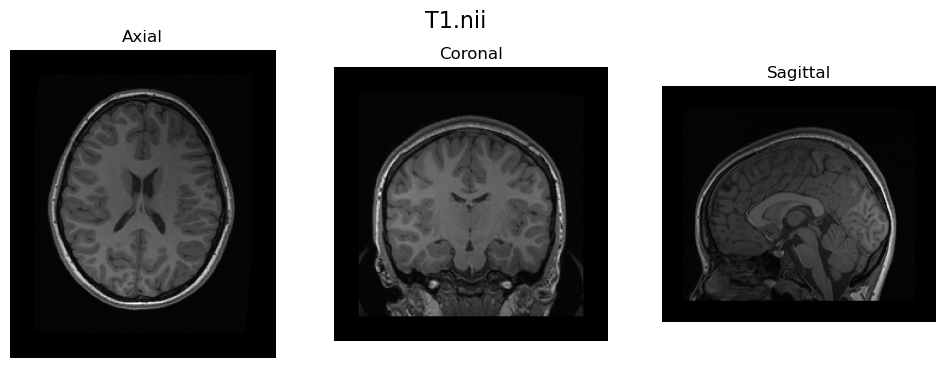

In [22]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

## Apply an affine transformation

**Exercise 2**: Write a function ```rotation_matrix(pitch, roll, yaw)``` which returns the rotation matrix for a given a roll, pitch, yaw. Make a 4x4 affine matrix with a pitch of 25 degrees.

In [23]:
def rotation_matrix(pitch, roll, yaw, deg = False):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R

pitch=25
rot_mat = rotation_matrix(np.deg2rad(pitch),0,0)
print(rot_mat)

[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779 -0.42261826  0.        ]
 [ 0.          0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]


In [24]:
# The point of this exercise is that you test your understanding of the rotation matrix, and that you have implemented it properly.

**Exercise 3**: Apply the rotation to the ImgT1.nii and save the rotated images as ImgT1_A.nii

In [25]:
# Define the roll rotation in radians
angle = 25  # degrees
pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

**Exercise 4**: Visualise ImgT1_A in ortho view and show the rotated image.

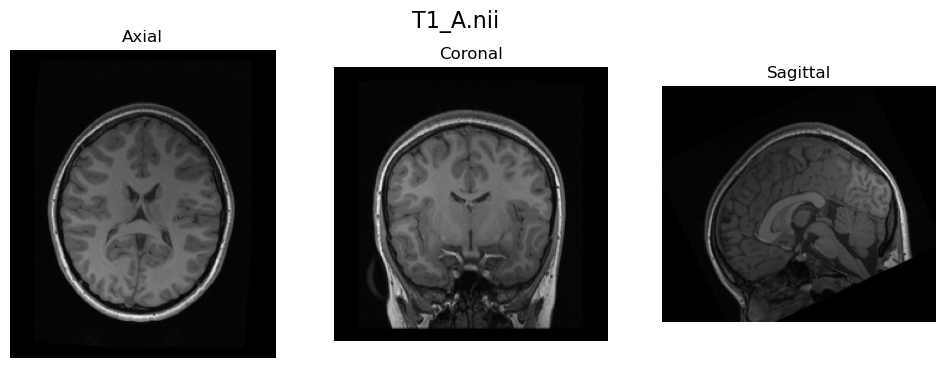

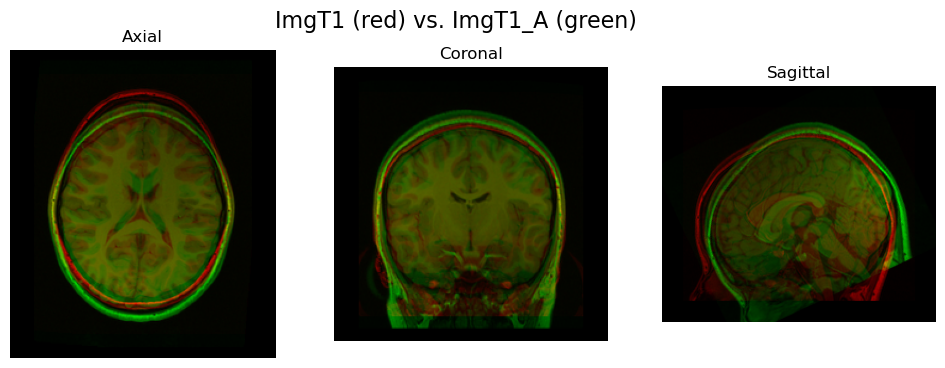

In [26]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

## Registration of a moving image to a fixed image

**Exercise 5**: Find the geometrical transformation of the moving image to the fixed image. The moving image is ImgT1_A.nii and the fixed image is ImgT1.nii. The new rotated image is named ImgT1_B.nii and the optimal affine transformation matrix text file is named A1.txt. You can try to modify the metric and optimizer step length.

In [27]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

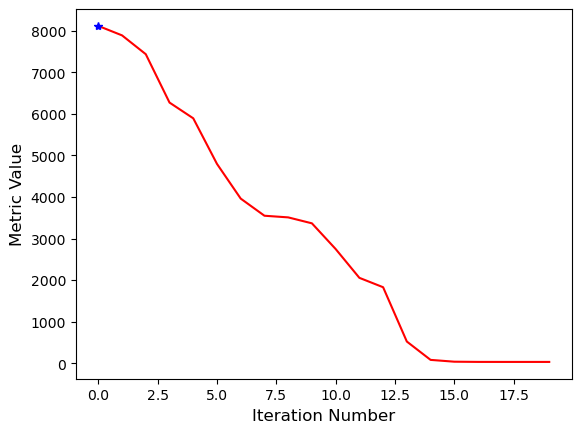

In [28]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the initial transform 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to help with the iteration
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
R.AddCommand(sitk.sitkStartEvent, start_plot)
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

tform_reg = R.Execute(fixed_image, moving_image)
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

**Exercise 6**: Show the ortho-view of the ImgT1_B.nii. Write the optimal affine matrix found. Does it agree with the expected and what is expected?

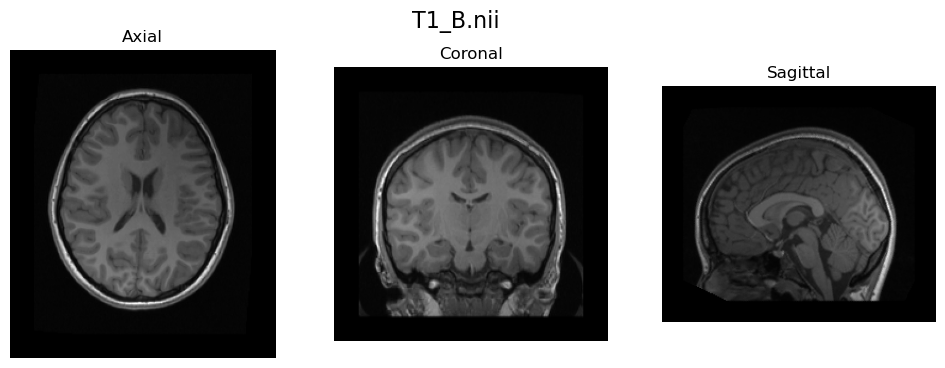

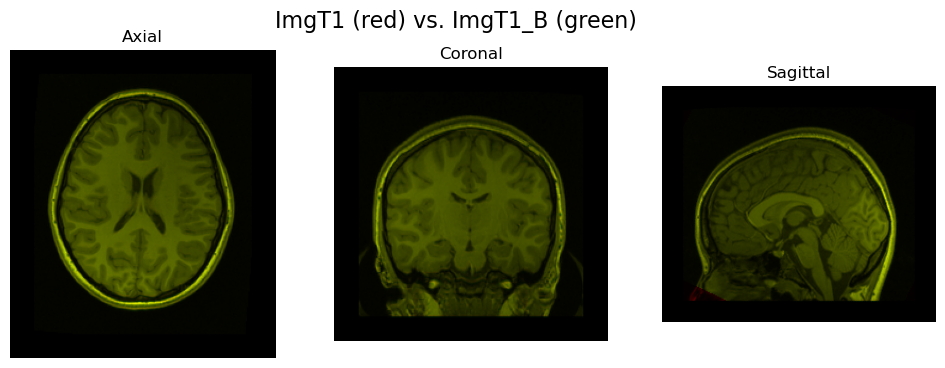

In [29]:
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')
overlay_slices(fixed_image, ImgT1_B, title = 'ImgT1 (red) vs. ImgT1_B (green)')
tform_reg.WriteTransform(dir_in + 'A1.tfm')

In [30]:
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

In [31]:
matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 3))
# But we dont get the identity because the centre of rotations were different!
# All the difference is in the translation component

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 3))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 3))

AttributeError: 'Transform' object has no attribute 'GetNthTransform'

**Exercise 7**: By default, sitk.Euler3DTransform() uses the fixed image’s origin as the rotation center. Change the rotation center to the center of the image and repeat the registration. Compare the optimization and the results.

In [ ]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
R.AddCommand(sitk.sitkStartEvent, start_plot)
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

tform_reg = R.Execute(fixed_image, moving_image)
ImgT1_B = sitk.Resample(moving_image, tform_reg)

In [ ]:
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')
overlay_slices(fixed_image, ImgT1_B, title = 'ImgT1 (red) vs. ImgT1_B (green)')

In [ ]:
matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 3)) # Should be identity matrix

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 2))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

In [ ]:
# The optimization is faster if we set the centre of rotation to the centre of the image (We are closer to the optimal solution)
# The translation component of the estimated matrix is now zero

## Generate a series of rotated 3D images 

**Exercise 8**: Make four rotation matrices that rotate the ImgT1nii in steps of 60 degrees starting from 60 degrees. Apply the rotation to ImgT1.nii, reslice and store the resulting images as ImgT1_60.nii, ImgT1_120.nii etc.  Show in ortho-view that the rotations are applied as expected for each new image.

In [ ]:
pitch_buffer = np.arange(1, 5)*60

for i, angle in enumerate(pitch_buffer):
    # Define the roll rotation in radians
    pitch_radians = np.deg2rad(angle)

    # Create the Affine transform and set the rotation
    transform = sitk.AffineTransform(3)

    centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
    centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
    rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

    transform.SetCenter(centre_world) # Set the rotation centre
    transform.SetMatrix(rot_matrix.T.flatten())

    # Apply the transformation to the image
    output = sitk.Resample(vol_sitk, transform)

    # Visualize the rotated image
    imshow_orthogonal_view(output, title=f'ImgT1_{angle}.nii')
    
    # Save the rotated image
    sitk.WriteImage(output, f'{dir_in}ImgT1_{angle}.nii')

**Exercise 9**: Use ImgT1_120.nii as the fixed image, and the other three rotated images from Exercise 8 as the moving images. Run the registration to find the affine matrix and include the reslicing procedure for each of the moving images. Show in ortho-view the resliced images and describe what the rotation angles are. Save the transforms with the name "Ex10_60.tfm, Ex10_120.tfm, Ex10_240.tfm" Do the rotations agree with those in Exercise 8?

In [ ]:
# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=20, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration - Instead of a plot, we print
#  iter = metric value : (Rx, Ry, Rz, Tx, Ty, Tz)
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

fixed_image = sitk.ReadImage(dir_in + 'ImgT1_120.nii')
pitch_buffer = np.array([60, 180, 240])
for i, angle in enumerate(pitch_buffer):
    
    moving_image = sitk.ReadImage(dir_in + f'ImgT1_{angle}.nii')

    # Set the initial transform 
    initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    R.SetInitialTransform(initTransform, inPlace=False)

    # Execute the registration
    tform_reg = R.Execute(fixed_image, moving_image)
    tform_reg.WriteTransform(dir_in + f'Ex9_{angle}.tfm')

    params = tform_reg.GetParameters()
    angles = params[:3]
    print(f'Estimated rotation (deg) for ImgT1_{angle}.nii: ')
    print(np.round(np.rad2deg(angles), 3))

    img_tmp = sitk.Resample(moving_image, tform_reg)
    # imshow_orthogonal_view(img_tmp, title=f'Registered ImgT1_{angle}.nii to ImgT1_120.nii')
    overlay_slices(fixed_image, img_tmp)

In [ ]:
tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')

params = tform_60.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

params = tform_180.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

params = tform_240.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

## Registration of a series of 3D images

Often, we wish to combine affine matrixes from a series of images with different registration but apply reslicing only once. The reason is that every time applying reslicing it introduces blurring, and if the image is registered and resliced at each step in a series of rotations, the final image will become very affected by blurring. This we can avoid by first finding the transformation matrix per registration step, then combining them into one matrix, and then applying the reslicing as the final step to the combined affine transformation.

**Exercise 10**: Use the ImgT1_240.nii as the fixed image and use the ImgT1.nii as the moving image. Make an affine matrix clockwise by combining the estimated transformation and the affine matrix obtained at each rotation step in exercise 10 and apply reslicing. Show in ortho views that the ImgT1.nii after applying the combined affine matrix is registered as expected. Show the combined affine matrix and explains if it applies the expected rotation angle.

In [ ]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image)
tform_reg.WriteTransform(dir_in + 'Ex10_0.tfm')

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image, tform_reg)
# imshow_orthogonal_view(img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')
overlay_slices(fixed_image, img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')

In [ ]:
params = tform_reg.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

In [ ]:
# Load the transforms from file
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')
tform_0 = sitk.ReadTransform(dir_in + 'Ex10_0.tfm')

In [ ]:
# Concatenate in an ITK way - The last added transform is applied first
tform_composite = sitk.CompositeTransform(3)

tform_composite.AddTransform(tform_240.GetNthTransform(0)) 
tform_composite.AddTransform(tform_180.GetNthTransform(0))
tform_composite.AddTransform(tform_60.GetNthTransform(0))
tform_composite.AddTransform(tform_0.GetNthTransform(0))

img_tmp = sitk.Resample(moving_image, tform_composite)
imshow_orthogonal_view(img_tmp, title='Output of the composite transform applied to ImgT1.nii')

In [ ]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [ ]:
affine_composite = composite2affine(tform_composite, centre_world)

# Since we are using just Euler transformations, we can map it to a rigid transform
euler_composite = sitk.Euler3DTransform()
euler_composite.SetMatrix(affine_composite.GetMatrix())
euler_composite.SetTranslation(affine_composite.GetTranslation())
euler_composite.SetCenter(affine_composite.GetCenter())

params = euler_composite.GetParameters()
angles = params[:3]

print(f'Estimated rotation (deg) for the composite transformation: ')
print(np.round(np.rad2deg(angles), 2))

print(f'Estimated homogeneous matrix: ')
print(np.round(homogeneous_matrix_from_transform(euler_composite),2))

In [ ]:
# Option B
A = np.eye(4)
for i in range(tform_composite.GetNumberOfTransforms()-1, -1, -1):
    tform = tform_composite.GetNthTransform(i)
    A_curr = homogeneous_matrix_from_transform(tform)
    A = np.dot(A_curr, A)

tform = sitk.Euler3DTransform()
tform.SetMatrix(A[:3,:3].flatten())
tform.SetTranslation(A[:3,3])
tform.SetCenter(centre_world)

out = sitk.Resample(moving_image, tform)
imshow_orthogonal_view(out, title='Output of the composite transform applied to ImgT1.nii')
params = tform.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg) for the composite transformation: ')
print(np.round(np.rad2deg(angles), 2))
print(f'Estimated homogeneous matrix: ')
print(np.round(homogeneous_matrix_from_transform(euler_composite),2))

In [ ]:
# The composite result is a rotation of -240 deg  or 120 deg
# But you may get a different values of rotation such as [-60, +-180, +-180], which is equivalent to [-240, 0, 0] deg.

## Robustness in the registration and number of iterations

If the moving image becomes too noisy the registration becomes unstable due to the appealingly many local minima in the cost function - in other words, there exist many sub-optimal solutions to the “optimal” affine matrix. In this case, the registration will be very sensitive to the selection of the hyperparameters such as the step length and the number of iterations. Moreover, depending on the optimizer the estimated affine matrix may be very unstable and will change significantly if we repeat the registration at the same noise level (This is not a critical issue for the Powell optimizer in this problem).

We can increase the noise level in an image by setting the noise standard deviation say to sigma = 200. We use a normal distributed random generator to generate the noise which is added to the image.

**Exercise 11**: Use the ImgT1.nii as the fixed image and ImgT1_240.nii as the moving image. Increase the noise level of the moving image and register it to the fixed image and repeat the registration at the same noise-level five times for different step length. At what sigma level does the affine matrix start becoming unstable? Show the ortho-views of the noisy moving image.

In [ ]:
# Load the image
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')

# Add some noise to the moving image
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=200)
imshow_orthogonal_view(moving_image, title='Moving image')
imshow_orthogonal_view(moving_image_noisy, title='Moving image with noise')

sitk.WriteImage(moving_image_noisy, 'ImgT1_240_noisy.nii')

In [ ]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')

noise_sigma = 200
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=noise_sigma)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=200, numberOfIterations=10)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
overlay_slices(fixed_image, img_tmp, title='Overlay of the registered image with noise and the fixed image')

By using the pyramidal multi-resolution registration strategy, we can make the registration of the noisy moving image to the fixed image more robust. Here we use the Gaussian pyramid procedure where we keep the image resolution (i.e., the shrink factor) in the different steps of the pyramid but introduce blurring by using a Gaussian filter at different levels. At the highest level most blurring is added, and we only see the coarse details in the image to be registered. Then, we go to finer and finer levels of details by reducing the blurring factor. The pyramidal procedure is implemented in the registration function and typically three levels are used and we just set the sigma = [3.0, 1.0, 0.0].

**Exercise 12:** Register the noisy moving image using the pyramidal procedure. Try three levels of setting sigma=[3.0, 1.0, 0.0]. Repeat the registration procedure with different step lengths. Does the image registration become more insensitive to the step length? If not try increasing sigma=[5.0, 1.0, 0.0]. Can one use only 2 levels of the pyramid? What do you suggest of sigma values? Show the optimal affine matrices for each of the repeats to check robustness.

In [ ]:
noise_sigma = 200
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=noise_sigma)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=200, numberOfIterations=10) # stepLength= 10, 50, 150, 200

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2,2,2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,1,0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
# initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
overlay_slices(fixed_image, img_tmp, title='Overlay of the registered image with noise and the fixed image')